In [18]:
%run init_notebook.py

In [19]:
import pandas as pd
import numpy as np

import datetime as dt

In [20]:
from settings import OUT_DATA_DIR, WORK_DATA_DIR, OUT_MODEL_DIR

In [21]:
from utils.load import load_data, save_model, save_file
from utils.utils import tts_data
from src.src import ModelValidation, StatsTest, RandomWalk

In [22]:
# Load data
model_type = "rw"
data_len = 8055 # 440, 660, 760, 1560, 8055
is_sent = False
week_day = 'daily'
predicted = "sp_close_lead1"

year_start = 2011
year_end = 2021
year_spread = f'years{year_end}_{year_start}'

df_w = load_data(file_name=f"df_{week_day}_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_{week_day}_{data_len}.pkl", file_path=WORK_DATA_DIR)

In [23]:
if week_day == 'daily':
    assert is_sent is False, 'Treating non sentiment data'
    # training on X years
    df_w = df_w[(df_w["date"] >= dt.datetime(year=year_start, month=1, day=1).date())
             &(df_w["date"] <= dt.datetime(year=year_end, month=12, day=31).date())]
    print(f'data compromises {year_end - year_start + 1} years: {df_w.shape[0]} lines')
else:
    year_spread = 'yearsNA'
    df_w = cut_to_weekly_data(df_w, 'is_thu')

data compromises 11 years: 2637 lines


In [24]:
# update dict with model specific information
data_dict["model_features"].update(predicted=predicted)
data_dict["model_features"].update(datetime_ind=dict(zip(df_w.index, df_w.date)))

data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(data_len=data_len)
data_dict["model_metrics"].update(is_sent=is_sent)
data_dict["model_metrics"].update(week_day=week_day)
data_dict["model_metrics"].update(year_spread=year_spread)
data_dict["model_metrics"].update(model_name=f"{model_type}_{data_len}_{year_spread}_{data_dict['model_features']['predicted']}_sent{is_sent}")

In [25]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
     'sp_close',
]

categorical = [    
     # 'weekday',
     # 'weekday_0',
     # 'weekday_1',
     # 'weekday_2',
     # 'weekday_3',
     # 'weekday_4'
]

## categorical features
if len(categorical) > 0:
    cols = cols + categorical
    data_dict["model_features"]["categorical"] = categorical

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

# TTS

In [26]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

In [27]:
df_train = df_ws.copy()

In [28]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=.3,
                                            add_const=False)

# Model eval

In [29]:
model = RandomWalk(X_train, X_test)

In [30]:
rval = ModelValidation(X_train, y_train, X_test, y_test, model, print_results=True)

TTest one sample for mean: 0
Test statistics: [2.20303186]
Test pvalue: [0.02767873]
Population mean is equal to 0: [ True]


Testing for zero mean
Time series has a zero mean: True
Random walk requires a drift: False


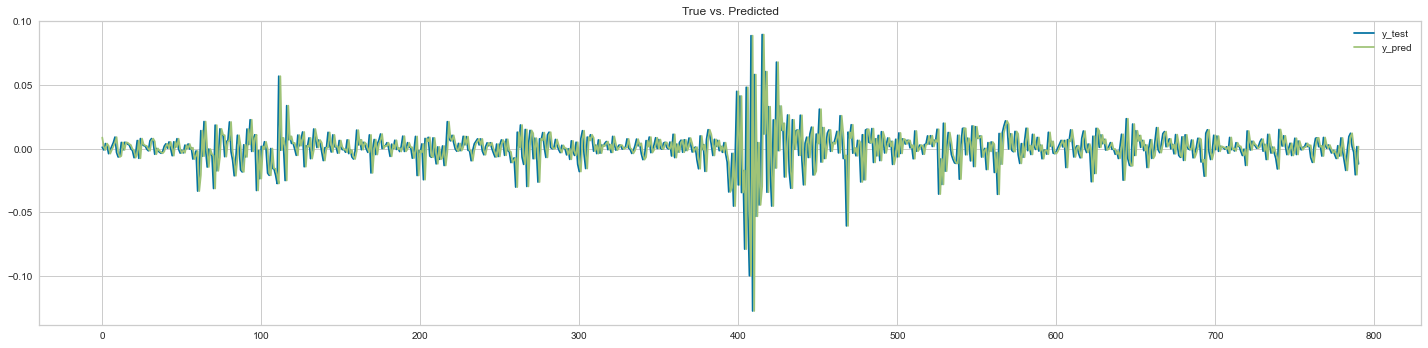

Validation Scores
root mean squared error: 0.0228203902
mean squared error: 0.0005207702
mean absolute error: 0.0128164835
R2: -1.5208960783


In [31]:
fig_truefit = rval.get_model_performance()

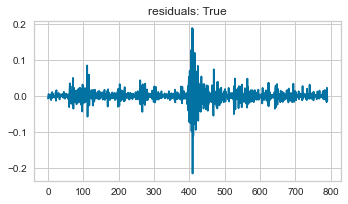

Stationarity Test Results
P-Values: 1.1746684444441561e-23
Test-stats: -12.68321782491382
Time series is stationary: True




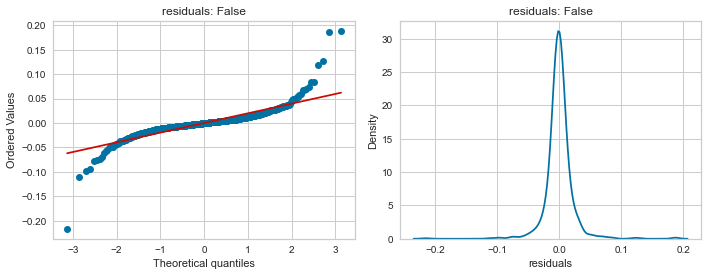

Normality Test Results
P-Values: 4.460943902613969e-56
Test-stats: 254.89880965333845
Series is normally distributed: False


HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


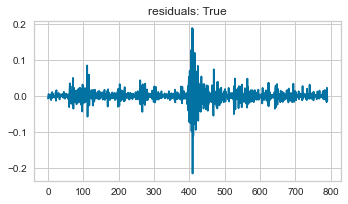

Test for Heteroskedasticity
Test p-value: 4.863838740618615e-124
Heteroskedasticity is present: True


TTest one sample for mean: 0
Test statistics: -0.03221966844549531
Test pvalue: 0.9743050094072905
Population mean is equal to 0: False


Durbin watson test for first oder autocorrelation
Test statistics: 1.5 < 3.37 < 2.5
First order autocorrlation is not present: : False


In [32]:
stat, norm, hetero, d_watson, zero_mean = rval.analyse_resids()

In [33]:
# update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)
data_dict["model_metrics"].update(d_watson_aucorr=d_watson)

# model performance
data_dict["model_metrics"].update(rmse=rval.rmse)
data_dict["model_metrics"].update(mse=rval.mse)
data_dict["model_metrics"].update(mae=rval.mae)
data_dict["model_metrics"].update(r2=rval.r2)
data_dict["model_metrics"].update(residuals=rval.resid_inv)

# Save model

In [34]:
save_model(model=rval.model, 
           df_train=df_train,
           data_dict=data_dict,
           plt_figures=[fig_truefit], 
           fig_titles=['fig_truefit',], model_dir=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-24_rw_8055_years2021_2011_sp_close_lead1_sentFalse"? (y/n)


 y
